# Logistic Regression on Smartphone Data

This data exploration uses the following dataset (modified for the course): [Human Activity Recognition Using Smartphones](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv)

The dataset was built from participants carrying smartphones embedded with inertial sensors while they were doing daily activities. These activities were classified into six categories: `['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']`.

The following is provided for each datapoint:
- Triaxial calculation form the accelerometer
- Triaxial angular velocity
- A 561-feature vector with time and frequency domain information
- Activity label

There are a total of 10299 datapoints. All columns (except the dcategory column) are floating point values scaled between -1.0 and 1.0. The categories are relatively evenly distributed and represented by a string variable.

In [16]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Exploring the data

First we check what the data looks like, there are a lot of compound measurements in the dataset, as indicated by the column names. These are all scaled ([-1.0, 1.0]) floating point values relating to the inertial measurements.

In [10]:
df = pd.read_csv("./data/Human_Activity_Recognition_Using_Smartphones_Data.csv")
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 44.2+ MB


Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [ ]:
# Distribution of datatypes
df.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [ ]:
# Distribution of values
df.iloc[:, :-1].min().value_counts(), df.iloc[:, :-1].max().value_counts()

(-1.0    561
 Name: count, dtype: int64,
 1.0    561
 Name: count, dtype: int64)

In [9]:
df.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

The category columns needs to be encoded before we can use it as a target variable in sklearn. For this we will use a labelencoder to interpret the categories as integers.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])

## Exploring Correlations

Since the columns are combinations of other features, there are likely correlations. For model performance we need to find these.

In [22]:
feature_cols = df.columns[:-1]
corr_values = df[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
# tril -> triangular_lower
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack() # drops na values by default
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()
corr_values.head(5)

,feature1,feature2,correlation,abs_correlation
0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.128037,0.128037
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.230302,0.230302
2,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.004590,0.004590
3,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.016785,0.016785
4,tBodyAcc-mean()-X,tBodyAcc-std()-Z,-0.036071,0.036071


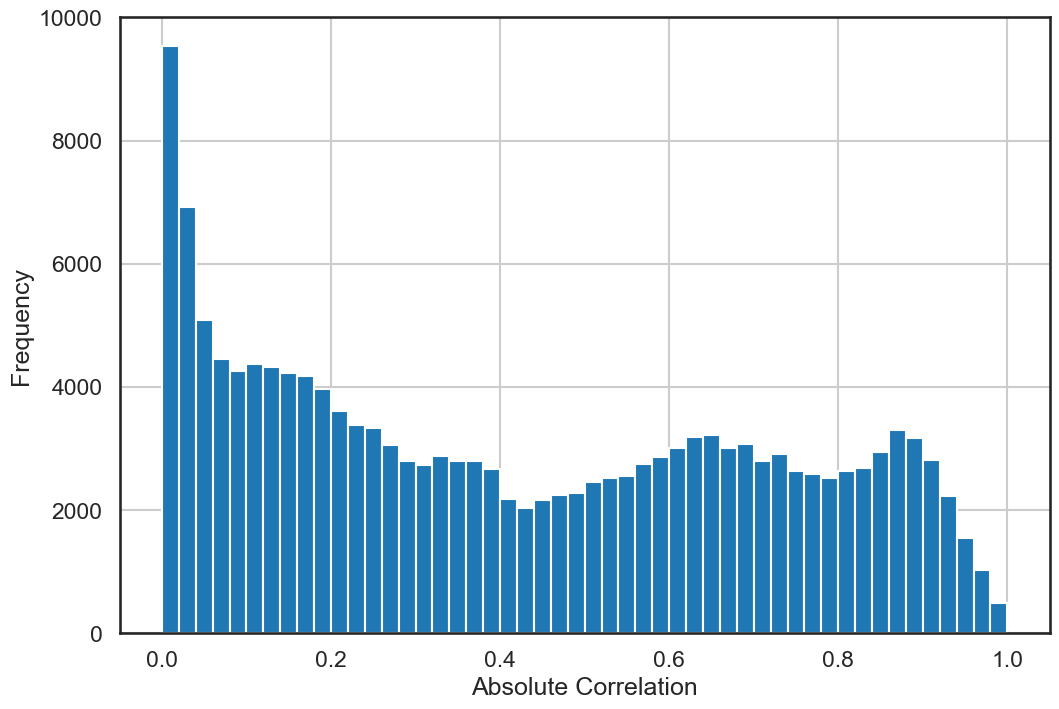

In [17]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

There are quite a bit of correlations, which is to be expected with 561 data columns. This leads to (561*561=314.721) / 2 (because we removed duplicates) = 157080 values. If we take a cutoff of >0.8 for correlations we want to consider (meaning 80% correlated), we get the following, leaving 22815 variables with high correlations.

In [24]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
156556,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
96366,tBodyAccMag-arCoeff()4,tGravityAccMag-arCoeff()4,1.000000,1.000000
109498,tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Preparing for training

To train the model we need to first split up the data. To keep the data categories consistent across splits, we will use `StratifiedShuffleSplit`. We only need a single split, but the stratification process ensures that the class distribution is as equal as possible between train and test sets.

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.3,
    random_state=42
)

# The stratified shuffle split splitter returns a generator that provides lists
# of indices to use for each split.
train_idx, test_idx = next(sss.split(df[feature_cols], df['Activity']))

X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'Activity']

X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, 'Activity']

## Fitting a model

With the data encoded and split up we can now fit a model to do some predictions. We'll do this for a basic model (without regularization). Then we can compare with regularized versions using cross validation.

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:508: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecate

## Comparing models

With the fitting done, we can compare the coefficients of the models.

In [30]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Making Predictions

